# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$.

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem.

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian.

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S)
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$.

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips:
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels

In [ ]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = None

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = None
params['c_u'] = None

In [ ]:
def compute_hfs(L, Y, soft=False, **params):
    """

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1

    """
    Build the vectors:
    y = (n x num_classes) target vector
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    y = np.zeros((num_samples, num_classes))
    for i in range(num_classes):
        y[Y == i+1, i] = 1
    l_idx = np.where(Y != 0)[0]
    u_idx = np.where(Y == 0)[0]
    f = np.zeros((num_samples, num_classes))

    if not soft:
        """
        Compute hard HFS.

        f_l = solution for labeled data.
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        f_l = y[l_idx]
        f_u = np.linalg.solve(L[np.ix_(u_idx, u_idx)], -L[np.ix_(u_idx, l_idx)]@f_l)
        f[l_idx] = f_l
        f[u_idx] = f_u

        # ...

    else:
        """
        Compute soft HFS.
        f = harmonic function solution
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise
        """
        C = np.zeros(num_samples)
        C[l_idx] = params['c_l']
        C[u_idx] = params['c_u']
        C = np.diag(C)
        f = np.linalg.solve(L + C, C@y) # Reformulation of f* = (L + C)^-1 C y
        # ...
    labels = np.ones(num_samples)
    labels += np.argmax(f, axis=1)
    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]
    f : harmonic function solution
    """
    return labels, f


In [ ]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, per_class=False, verbosity=True, **params):
    """

    HFS for two_moons data.

    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)

    # mask labels
    Y_masked = mask_labels(Y, l, per_class=per_class)
    if per_class and verbosity:
        print("Using per class masking")
    assert len(np.unique(Y_masked)) > 2, "only one class in training data! - Use per class masking"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'],
    # params['k'] and params['laplacian_normalization'].
    laplacian_params = {key: params[key] for key in ['laplacian_regularization', 'var', 'eps', 'k', 'laplacian_normalization']}
    L = build_laplacian_regularized(X, **laplacian_params)
    if soft and params['c_l'] is None and params['c_u'] is None:
        params['c_l'] = 1
        params['c_u'] = 1

    labels, f = compute_hfs(L, Y_masked, soft = soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    if verbosity:
        print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0.

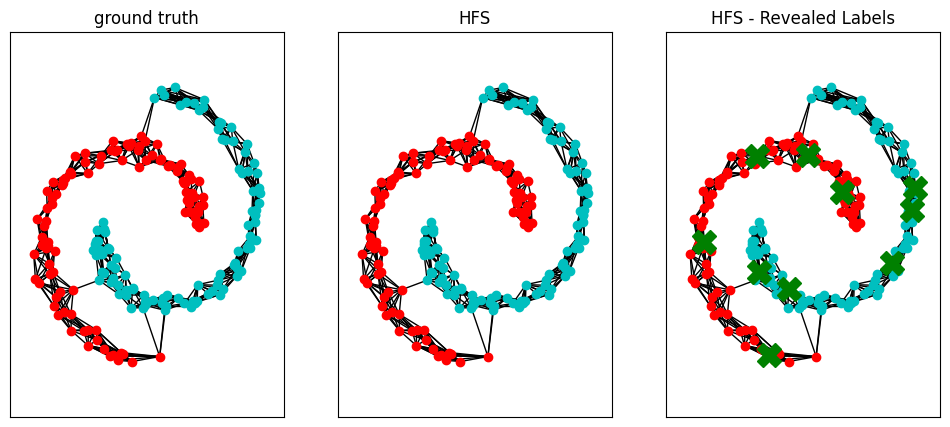

Soft=False, Accuracy=1.0


In [ ]:
# Parameters :
params['laplacian_normalization'] = 'unn'
params['k'] = 9

seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

> With our specific parameters we succesfully obtained an accuracy of $1$. Thus, we can conclude that such a labelling method does work in proper settings. At least for the Hard HFS method.


### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [ ]:
np.random.seed(42)
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False,
                                                     dataset='data_2moons_hfs_large.mat',
                                                     plot=False, seed=None, per_class=True, **params)

# mask_labels?  # check parameters

Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0
Using per class masking
Soft=False, Accuracy=1.0


> We had to modify the original `two_moons_hfs` function because we had a problem with the number of class obtained in this peculiar situation. Indeed if $l<<\frac{n}{n_{classes}}$ such as $l=4$ in our case, then we take the risk of obtaining not enough different classes for the labeled data. A way to always obtain at least $2$ classes would be to take :
<br>
>$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad l>min\{k\in\mathbb{N}\; s.t \; k=\text{"nb of point in one of the classes"}\}$
<br><br>
> But as this is not always possible, we will need to "cheat". Indeed, we will need to use `per_label` arguments which allow us to reveal $l$ label per classes. Doing so, we cheat because we allow ourselves to have a complete access to the labeling in order to check the number of classes. But this is not completely irrealist. In fact, one could expect that during the first basic labeling process done by an operator (human or something else), the data where correclty processed and at least one object was labeled for each class. But ultimately, this would require us to check that the dataset is well built before applying our method.
<br><br>
> In any case, it appears that even with this little of labeled data we still managed to succesfully label the rest. Thus showing that our method yield impressive results.

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

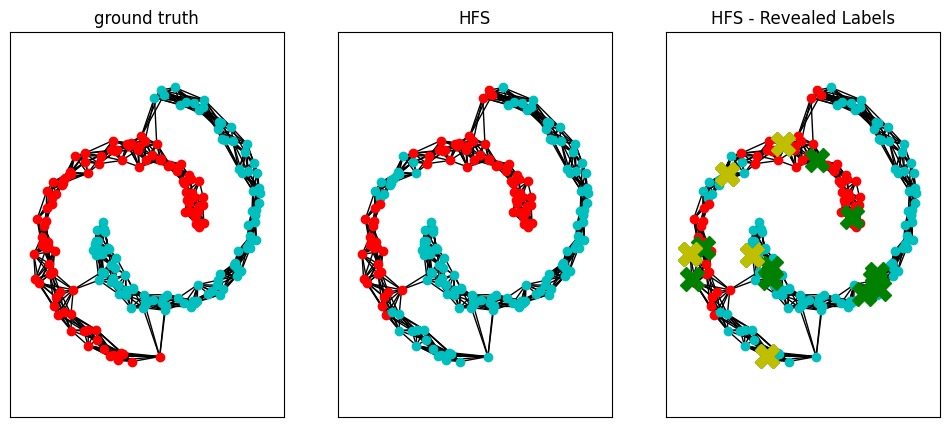

Soft=False, Accuracy=0.84


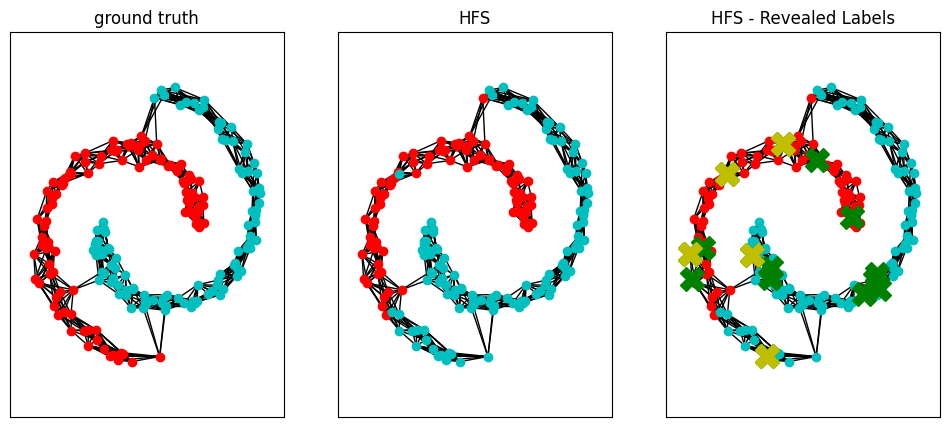

Soft=True, Accuracy=0.91


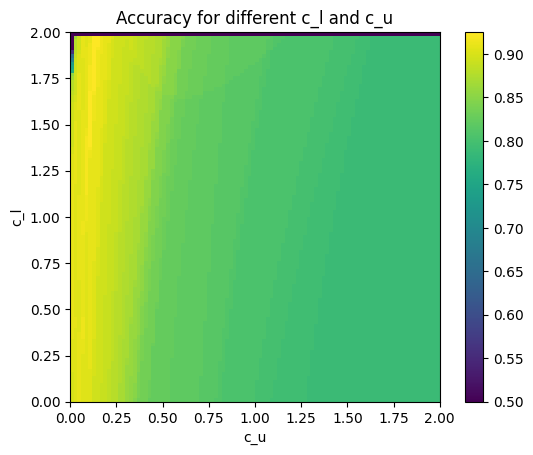

In [ ]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
params['laplacian_normalization'] = 'unn'
params['k'] = 10
params['c_l'] = 1.5
params['c_u'] = 0.05
plot = True
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
c_l_space = np.linspace(0., 2, 100)
c_u_space = np.linspace(0., 2, 100)
accuracy = np.zeros((len(c_l_space), len(c_u_space)))
for i, c_l in enumerate(c_l_space):
    for j, c_u in enumerate(c_u_space):
        params['c_l'] = c_l
        params['c_u'] = c_u
        X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                         plot=False, seed=seed, verbosity=False, **params)
        accuracy[i, j] = soft_accuracy
plt.figure()
plt.imshow(accuracy, extent=[c_u_space[0], c_u_space[-1], c_l_space[0], c_l_space[-1]])
plt.colorbar()
plt.xlabel('c_u')
plt.ylabel('c_l')
plt.title('Accuracy for different c_l and c_u')
plt.show()

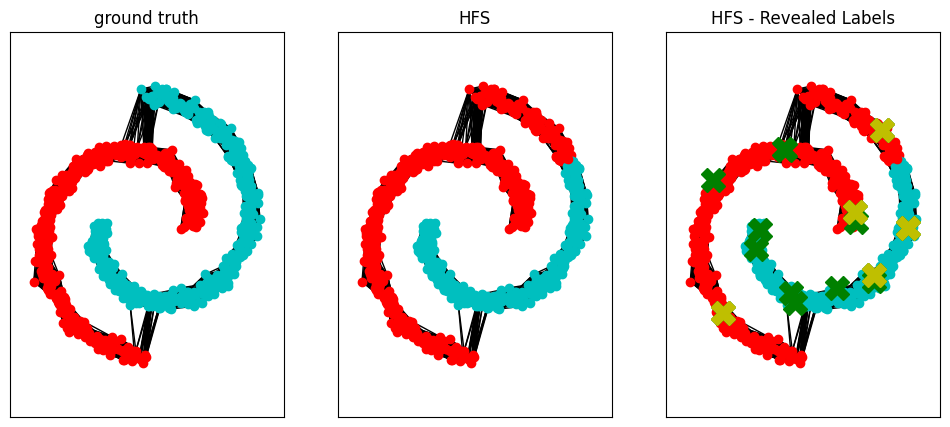

Soft=False, Accuracy=0.899


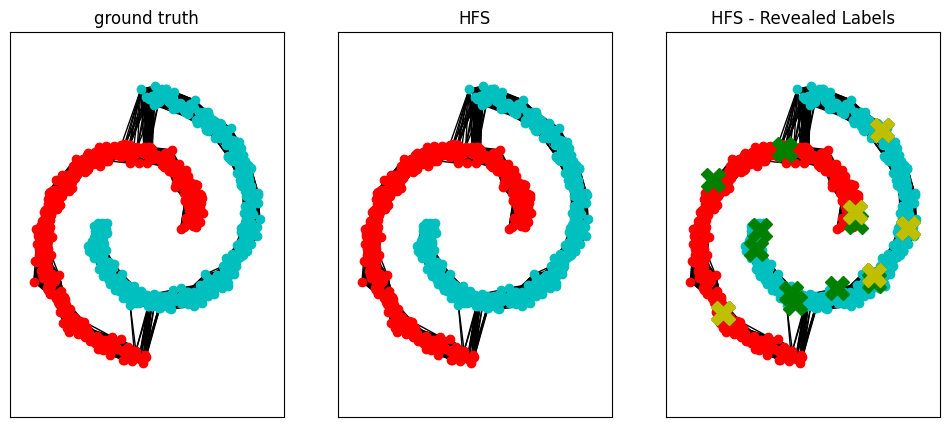

Soft=True, Accuracy=1.0


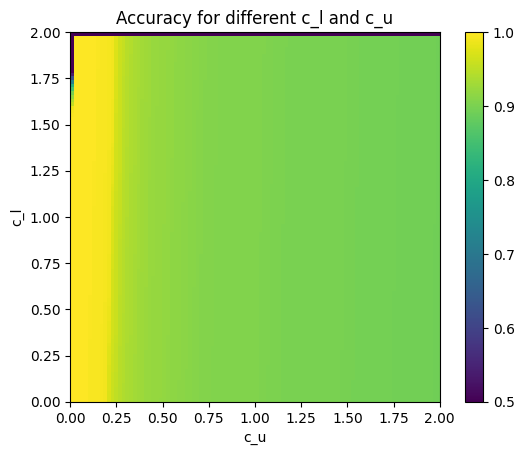

In [ ]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
params['laplacian_normalization'] = 'unn'
params['k'] = 50
params['c_l'] = 1.5
params['c_u'] = 0.05
plot = True
dataset = 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
c_l_space = np.linspace(0., 2, 100)
c_u_space = np.linspace(0., 2, 100)
accuracy = np.zeros((len(c_l_space), len(c_u_space)))
for i, c_l in enumerate(c_l_space):
    for j, c_u in enumerate(c_u_space):
        params['c_l'] = c_l
        params['c_u'] = c_u
        X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                         plot=False, seed=seed, verbosity=False, **params)
        accuracy[i, j] = soft_accuracy
plt.figure()
plt.imshow(accuracy, extent=[c_u_space[0], c_u_space[-1], c_l_space[0], c_l_space[-1]])
plt.colorbar()
plt.xlabel('c_u')
plt.ylabel('c_l')
plt.title('Accuracy for different c_l and c_u')
plt.show()

> We observe that indeed, using soft HFS, we obtain a better accuracy than classic hard HFS. But as we see that it is not a perfect accuracy, it would be interesting to compute it while moving the parameters of soft HFS : `c_l` and `c_u`.
<br><br>
> We compute a density map of the accuracy in function of `c_l` and `c_u`. The result that we obtain show us that choosing a low coefficient for the unlabeled data and a high one for labeled one yields better results. This is an expected observation, because we have obviously more trust in the "quality" of the labeling of the labeled data. But there is an important observation that we can do based on the map obtained. Recall that we have :
<br>
>$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad \min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f$
<br>
> Thus the $C$ weight matrix is giving weight to the regularization. Indeed, we have a regularization term which can be rewritten :
<br><br>
>$ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad(f-y)^T C (f-y) = c_l\|f_l-y_l\|_2^2 + c_u\|f_u\|_2^2$
<br><br>
> It is important to note that while the $l$-term make sure that the label produced are not to far from the noised label (this make sure we stay near the true label while allowing us to move so that to not have the noise impact our prediction), the $u$-term is a ridge regularization term. Taking a look at the map we can state the following fact : `c_l` need a high value while `c_u` require a low one to yield proper accuracy (`c_l`$\approx 1.5$ & `c_u`$\approx0.05$). Using what we said above, we can remark that to properly solve our problem we need for the ridge regularization weight to be low, thus not too much constraining on the $f_u$.

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

In [ ]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [ ]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 1.0
params_face_rec['var'] = 10000.0
params_face_rec['eps'] = None
params_face_rec['k'] = None
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = None
params_face_rec['c_u'] = None

In [ ]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image

    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # image = cv2.medianBlur(image, 5)
    # kernel_sharpening = np.array([[0, -1, 0],
    #                               [-1, 5, -1],
    #                               [0, -1, 0]])
    # image = cv2.filter2D(image, -1, kernel_sharpening)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float64)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

In [ ]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# # 50 images per person
# images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
# plot_image_data_augmented(images_a)

# Uncomment below if you want to visualize the images
# plot_image_data(images)
# print(images.shape)
# print(masked_labels.reshape(-1, 10))

In [ ]:
params_face_rec['eps'] = None
params_face_rec['k'] = 2
params_face_rec['laplacian_normalization'] = 'sym'
params_face_rec['c_l'] = 1.
params_face_rec['c_u'] = 0.01

In [ ]:
# graph Laplacian
L = build_laplacian_regularized(images,
                                params_face_rec['laplacian_regularization'],
                                params_face_rec['var'],
                                params_face_rec['eps'],
                                params_face_rec['k'],
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.82


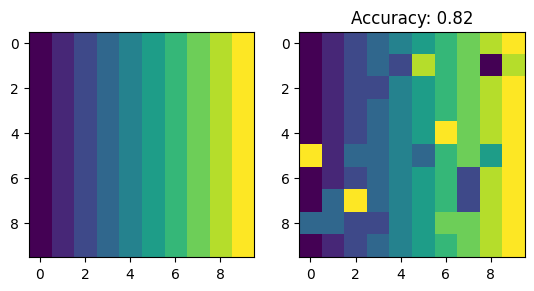

Unlabeled score: 0.7 # Percent of masked labels that where correctly predicted
Labeled score: 1.0 # Percent of unmasked labels that where correctly predicted
Number of unlabeled samples: 60 (100)


In [ ]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

# print(masked_labels)
# print(predicted_labels)
# print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()
# unlabeled score
print("Unlabeled score: " + str(np.equal(predicted_labels[masked_labels == 0], labels[masked_labels == 0]).mean()) + " # Percent of masked labels that where correctly predicted")
print("Labeled score: " + str(np.equal(predicted_labels[masked_labels != 0], labels[masked_labels != 0]).mean()) + " # Percent of unmasked labels that where correctly predicted")

# Number of unlabeled samples
print("Number of unlabeled samples: " + str(np.sum(masked_labels == 0)) + " (" + str(len(masked_labels)) + ")")

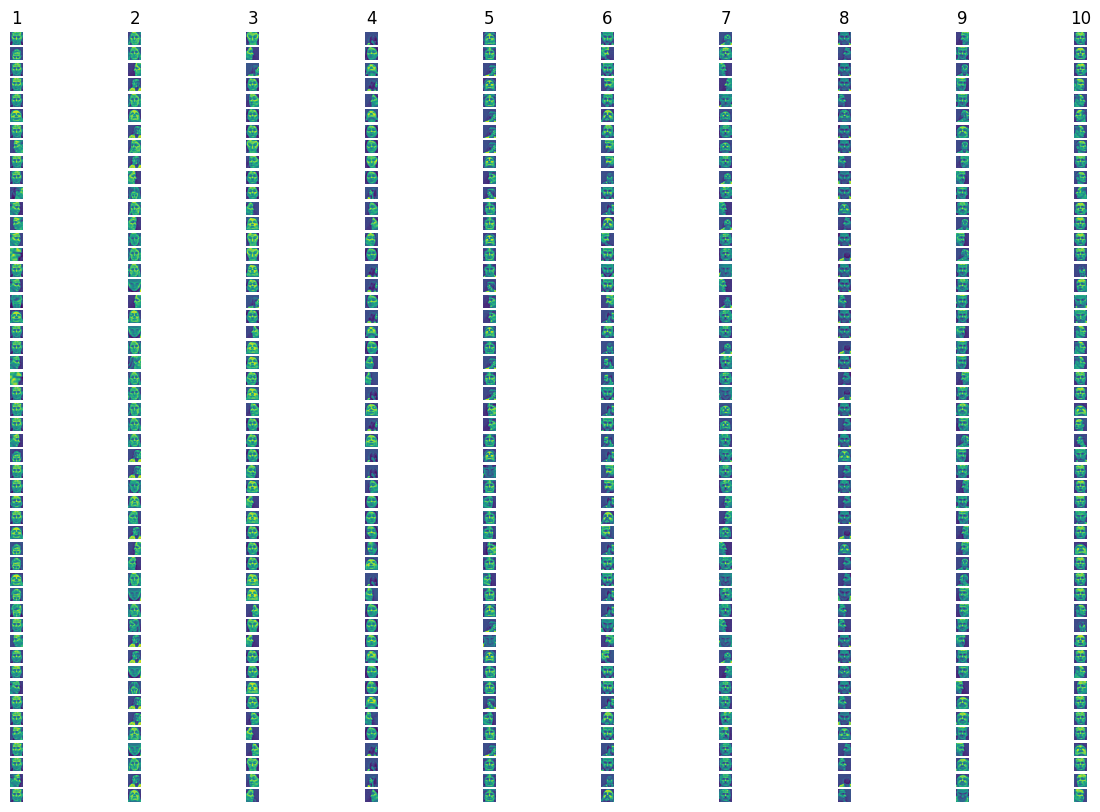

In [ ]:
# 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

In [ ]:
params_face_rec['eps'] = None
params_face_rec['k'] = 5
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['laplacian_regularization'] = 1.
params_face_rec['c_l'] = 1.5
params_face_rec['c_u'] = 0.05

In [ ]:
# graph Laplacian
L = build_laplacian_regularized(images_a,
                                params_face_rec['laplacian_regularization'],
                                params_face_rec['var'],
                                params_face_rec['eps'],
                                params_face_rec['k'],
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.584


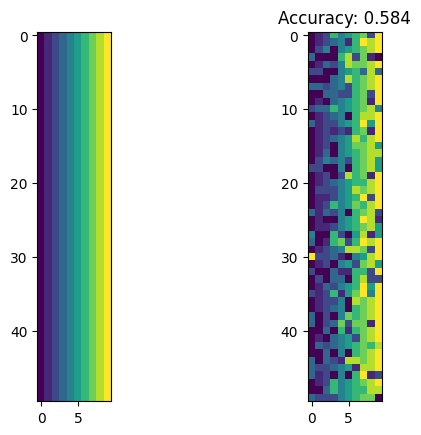

Unlabeled score: 0.5478260869565217 # Percent of masked labels that where correctly predicted
Labeled score: 1.0 # Percent of unmasked labels that where correctly predicted
Number of unlabeled samples: 460 (500)


In [ ]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels_a, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels_a).mean()
print("Accuracy = ", accuracy)

# print(masked_labels_a)
# print(predicted_labels)
# print(labels_a)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()
# unlabeled score
print("Unlabeled score: " + str(np.equal(predicted_labels[masked_labels_a == 0], labels_a[masked_labels_a == 0]).mean()) + " # Percent of masked labels that where correctly predicted")
print("Labeled score: " + str(np.equal(predicted_labels[masked_labels_a != 0], labels_a[masked_labels_a != 0]).mean()) + " # Percent of unmasked labels that where correctly predicted")
# Number of unlabeled samples
print("Number of unlabeled samples: " + str(np.sum(masked_labels_a == 0)) + " (" + str(len(masked_labels_a)) + ")")

### Question 2.1 - How did you manage to label more than two classes?

> To label more than two classes, we need to change the dimension of the $y$ given to our process. Indeed, in the original formula, $y\in\mathbb{R}^{n}$ where $y_i$ take the value $0$ for unlabeled data and $1$ otherwise. But now we need to operate multiple class labeling (for more than two classes). Thus, we introduced a new $y$ matrix : $y\in\mathbb{R}^{n\times n_{classes}}$ where $y_{ij} = 0$ if the $i^{th}$ sample is not labeled as the $(j+1)^{th}$ classes (the $+1$ originate from indexation issues as $0$ represent unlabeled data), and $y_{ij} = 1$ if the $i^{th}$ sample is labeled as the $(j+1)^{th}$ classes. This ultimately implies that the output $f\in\mathbb{R}^{n\times n_{classes}}$ (harmonic function) but we don't expect it to be exactly $\{0,1\}$-valued, therefore we will have to assign the label using the following method :
<br>
> $\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad y^*_i = \argmin_{j\in\{1,\cdots,n_{classes}\}}\{y_{ij}\}$
<br>
> Where $y^*_i$ is the computed label for $x_i$.
<br><br>
> This is called `one hot encoding`

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person).

> We first compute the harmonic function for the small dataset and obtain the labeling. After obtaining those predicted labels we compute the accuracy : $Acc_{small}\approx 0.82$.
<br>
> By taking a more precise look at which label where unproperly associated, we observe that we perfectly fitted the labeled data (even if their is possibly some noise) but we poorly predicted the others labels.
<br><br>
> This issue increase when faced to the augmented dataset. Indeed, we obtain a much smaller accuracy : $Acc_{big}\approx 0.58$ (Maximal accuracy obtained after testing the modification of preprocessing image commented in the preprocess function). This shows that such a labeling process is limited and does not always yield good results. Furthermore, this give us insight on how to answer the next question :

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

> The accuracy was reduced after augmenting the dataset size. Thus, we observe that an increase in the number of samples is not correlated to an increase in performance. We could have expected to obtain a more accurate results because we would had more data to represent each distribution of each classes therefore making the computation more stable. But this is not the case, in fact we have a huge decrease in the accuracy.
<br><br>
> To understand properly what is happening, we need to know the number of a priori unlabeled data. For the first dataset, we have $\frac{60}{100}=0.6$ percents of the data which are unlabeled. While, for the augmented dataset, we have $\frac{460}{500}=0.92$ percents of the data which are unlabeled. This ultimately means that we have almost all the data that are unlabeled. Remember that our methods use a ridge regularization on unlabeled data, thus if part of the data were to be uncorecctly labeled then the error could spread. To be more precise : If for some unlabeled sample, we have an increase of the norm of the label vector (which is in $\mathbb{R}^{n_{classes}}$), then we risk to have a reduction in others vectors norms (ridge reduce the overall norms) implying an unstable prediction. Unfortunately, the less label we have, the more this unstability results in error spreading.
<br><br>
Therefore, we can conclude that increasing the data could results in reduced accuracy if the data are unlabeled. However, if they are indeed labeled, this would reduce the ratio $\frac{\text{\#unlabeled}}{\text{\#unlabeled}+\text{\#labeled}}$ which we could expect to results in a higher accuracy.

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$.

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`.

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition.

* Tips:
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

> A first results on myself : I took a dataset of $10$ images of me with a white wall behind, then a video on another environment and to finish, a video of myself outside doing tree climbing (the video is harder to classify). It appears that our algorithm work even if -considering the score obtained- it has a hard time when the background change (as described above) :
<br><br>
![Resulting Frame](results/frame_1.png)
<br><br>
> Here the image where the algorithm did not recognize me. To be clearer, the algorithm gave a score of $0.47$ that the class of this image of me was indeed myself (`Raphael`). I have set the threshold of uncertainty for our algorithm to $0.5$, thus, I was classified as `unknown` (Find more explanations in question 3.2).
<br><br>
![Resulting Frame](results/frame_3.png)
<br><br>
> And then, I have also tried it on image of Terence Tao, famous Fields medaled mathematician (dataset $=36$ images). It appears that the algorithm do appreciate Tery because it had no difficulty to classify him :
<br><br>
![Resulting Frame](results/frame_4.png)
![Resulting Frame](results/frame_5.png)
<br><br>
> Well not always perfectly (low score) ;-P
<br><br>
![Resulting Frame](results/frame_2.png)

### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


> The strategy is quite simple : if someone's face appears on the camera (or video) with a lower scores (for all classes scores) than a given threshold (here, fixed at $0.5$), then this person is labeled as `unknown`. If we where not to add such a process, then all the mathematician would be recognized as Terence Tao or myself (with a low scores), which is not that much terrible for me but would clearly be for famous mathematician.
<br><br>
> I took an interview video of Cedric Villani, another Fields medaled mathematician. And he was indeed, labeled as `unknown` (even if he isn't in the real life, he is quite famous for his "spider") :
<br><br>
![Resulting Frame](results/frame_6.png)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [ ]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 1.0
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = None
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = None
params_online_ssl['c_u'] = None

In [ ]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels

        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None

    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        Update centroids, multiplicity vector V, labels Y.

        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample

        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.

            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            n_centroids = self.centroids.shape[0]
            dist = self.centroids_distances
            sorted_dist = np.argsort(dist, axis=None)
            k = 0
            c_1, c_2 = np.unravel_index(sorted_dist[k], dist.shape)
            while (c_1 in self.taboo and c_2 in self.taboo) or (c_1 == c_2): # if c_1 and c_2 are in taboo we need to find another couple
                c_1, c_2 = np.unravel_index(sorted_dist[k], dist.shape)
                k += 1
                if k >= n_centroids**2:
                    print("Error: no correct centroid couple maybe taboo set contain all centroid.")
                    return None
            if c_1 in self.taboo:
                c_rep, c_add = c_1, c_2
            elif c_2 in self.taboo:
                c_rep, c_add = c_2, c_1
            elif self.V[c_1] <= self.V[c_2]:
                c_rep, c_add = c_1, c_2
            else:
                c_rep, c_add = c_2, c_1


            """
            Update data structures: self.centroids and self.V
            """
            self.V[c_rep] += self.V[c_add]
            self.V[c_add] = 1
            self.centroids[c_add] = face


            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self, unknown_threshold=0.5):
        """
        Returns a prediction corresponding to self.last_face.
        Parameters
        ----------
        unknown_threshold : float
            Threshold under which the unknown label is returned.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)

        # Build quantized graph and its regularized Laplacian

        W = build_similarity_graph(self.centroids, var=params_online_ssl['var'], eps=params_online_ssl['eps'], k=params_online_ssl['k'])
        W = V @ W @ V # W_q = V W^tilde V
        L = build_laplacian(W, laplacian_normalization=params_online_ssl['laplacian_normalization'])
        # compute Q
        Q = L + params_online_ssl['laplacian_regularization']*np.eye(W.shape[0])

        # Compute the hard HFS solution f.
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))

        # handle unknown faces
        if np.max(f[self.last_face, :]) < unknown_threshold:
            return [("unknown", np.max(f[self.last_face, :]))]

        return label_scores



In [ ]:
# I will be using a video because my webcam is not linked to my virtual machine

# create_user_profile('Raphael', video_filename = 'data/video_rapha_1.mp4')         # choose your names here :)
# create_user_profile('Terence', video_filename = 'data/video_terence_tao_1.mp4')
# online_face_recognition(['Raphael', 'Terence'], IncrementalKCenters, n_pictures=10, video_filename = 'data/video_rapha_3.mp4')
# online_face_recognition(['Raphael', 'Terence'], IncrementalKCenters, n_pictures=10, video_filename = 'data/video_terence_tao_2.mp4')
# online_face_recognition(['Raphael', 'Terence'], IncrementalKCenters, n_pictures=10, video_filename = 'data/video_villani_1.mp4')

# Unfortunately, I could not found a video of Terence Tao and me in the same room. I wonder why :D

Profile found with 10 images.
Profile found with 36 images.
saved
Image saved at results/frame.png


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class.

* Tips:
    * Think back to the idea of incremental clustering as unsupervised classification

In [ ]:
from helper_online_ssl import increasing_online_face_recognition

profile_names = ['Raphael', 'Terence']
file = 'data/video_villani_1.mp4'
n_pictures = 15
max_centroids = 50
if len(profile_names)*n_pictures > max_centroids:
    print("Error: number of centroids is too small to allow creation of new profiles during the process. Please increase max_centroids.")

increasing_online_face_recognition(profile_names,
                            IncrementalKCenters,
                            n_pictures=n_pictures,
                            max_centroids=max_centroids,
                            acc_threshold=0.4,
                            unknown_threshold=0.7,
                            video_filename=file)

Profile found with 10 images.
Profile found with 36 images.
New mathematician recognized : mathematician n°1
saved
Image saved at results/frame.png


> I have implemented the function `increasing_online_face_recognition` which can be found in the file `helper_online_ssl` (line $112$ to $271$). I will explain how does it work :
<br><br>
> To implement such a method, we need first to stock the `unknown` face that are detected at each frame. We stock them and in case they become centroid, we also stock the centroid indices (this will help us later). Then, if we have enough faces (`n_pictures`, same number for each dataset), we can try to add a new label (a new mathematician, because what would we add if not that ?). To do so, we check if their is one of the unlabeled centroid which is near enough of our `unknown` faces, this step implies that we make sure that : `max_centroids` $\geq$ `n_pictures` $\times$ len(`profil_names`) $+1$ which is not absurd because if it is not verifyed it would be impossible to have unlabeled centroid (thus create new classes). If we found such a centroid, we can label it as a new class with the name `mathematician n°1`. Then it is important to check wether the other unlabeled centroid are also faces of our new mathematician. If so, we label them with this same new class. And finally, we delete from the `unknown` dataset the faces that are near the faces labeled as `mathematician n°1`.
<br><br>
> By introducing such a process in the loop of classification, we can slowly increase the number of mathematician recognized (unfortunately, we can only tell that they are not Tery or myself).
<br><br>
> We succesfully recognized Villani as a new mathematician :
<br><br>
![Resulting Frame](results/frame_7.png)

### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

In [3]:
# Necessary :
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image

    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # image = cv2.medianBlur(image, 5)
    # kernel_sharpening = np.array([[0, -1, 0],
    #                               [-1, 5, -1],
    #                               [0, -1, 0]])
    # image = cv2.filter2D(image, -1, kernel_sharpening)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float64)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

### Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from helper import mask_labels
from sklearn.semi_supervised import SelfTrainingClassifier

# Construct dataset (can be changed for another dataset - ex smaller face dataset)
images, labels, _ = load_image_data_augmented(preprocess_image)
Y = np.copy(labels)
X = images

# Loop over different values of K :
for K in [5, 10, 15, 20, 25]:
    print("#"*50+f"K = {K}"+"#"*50)
    # Randomly mask K labels per classes
    masked_labels = mask_labels(labels, K, per_class=True)
    Y = np.copy(labels)
    Y[masked_labels == 0] = 0

    # computation of l and u
    l = np.sum(masked_labels != 0)
    u = np.sum(masked_labels == 0)
    print(f"Number of labeled samples (l): {l}")
    print(f"Number of unlabeled samples (u): {u}")
    print(f"Percentage of labeled samples: {l/(l+u)*100:.2f}%")

    # Labeled and unlabeled sets
    labeled_indices = np.where(Y != 0)[0]
    unlabeled_indices = np.where(Y == 0)[0]

    X_labeled = X[labeled_indices]
    Y_labeled = Y[labeled_indices]

    X_unlabeled = X[unlabeled_indices]

    X_train, X_test, Y_train, Y_test = train_test_split(X_labeled, Y_labeled, test_size=0.2, random_state=42)

    # Supervised Learner - Random Forest
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, Y_train)
    Y_pred_supervised = rf_model.predict(X_test)
    supervised_accuracy = accuracy_score(Y_test, Y_pred_supervised)
    print(f"Supervised Accuracy: {supervised_accuracy}")

    # Semi-Supervised Learner - Self-Training with Random Forest
    self_training_model = SelfTrainingClassifier(RandomForestClassifier(), criterion='k_best', k_best=10)
    X_combined = np.vstack((X_train, X_unlabeled))
    Y_combined = np.hstack((Y_train, (-1)*np.ones(len(X_unlabeled))))
    self_training_model.fit(X_combined, Y_combined)
    Y_pred_self_training = self_training_model.predict(X_test)
    self_training_accuracy = accuracy_score(Y_test, Y_pred_self_training)
    print(f"Semi-Supervised Self-Training Accuracy: {self_training_accuracy}")

##################################################K = 5##################################################
Number of labeled samples (l): 50
Number of unlabeled samples (u): 450
Percentage of labeled samples: 10.00%
Supervised Accuracy: 0.8
Semi-Supervised Self-Training Accuracy: 0.7
##################################################K = 10##################################################
Number of labeled samples (l): 100
Number of unlabeled samples (u): 400
Percentage of labeled samples: 20.00%
Supervised Accuracy: 0.75
Semi-Supervised Self-Training Accuracy: 0.7
##################################################K = 15##################################################
Number of labeled samples (l): 150
Number of unlabeled samples (u): 350
Percentage of labeled samples: 30.00%
Supervised Accuracy: 0.8333333333333334
Semi-Supervised Self-Training Accuracy: 0.7666666666666667
##################################################K = 20##################################################
Number

In [ ]:
print("#"*50+f" Supervised data all-knowing "+"#"*50)
Y = np.copy(labels)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Supervised Learner - Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, Y_train)
Y_pred_supervised = rf_model.predict(X_test)
supervised_accuracy = accuracy_score(Y_test, Y_pred_supervised)
print(f"Supervised Accuracy: {supervised_accuracy}")
print("Compare with the accuracy of the semi-supervised learner found in the above cell")

################################################## Supervised data all-knowing ##################################################
Supervised Accuracy: 0.9
Compare with the accuracy of the semi-supervised learner found in the above cell


> The first statement we can make is that the semi-supervised learner always under perform compared to the supervised one. This is posibly due to the fact that the task we are currently given is to classify a test dataset which is a small parts of the total dataset. Indeed, for a small dataset which is highly similar to the training dataset, a supervised learner will often perform better. And that is because such a process will -at some point- overfitt on the small part of data it was given to train. But we could expect that with a less clearer data distribution, the semi-supervised would be more robust. In any case, in this current situation with small dataset of very close data (Here, I mean small also based on the number of element by classes) it would be wiser to use supervised.
<br><br>
> The second statement is that the all-knowing supervised model is not the optimal one. This could appears to be surprising but this is explainable : First, it is possible that the way the data were chosen impacted a lot the accuracy (with small dataset we have high variation). Second, having a bigger dataset augment the generalization capacity which will often results in a lower accuracy (because we have less overfitting on the data) if tested on small dataset. Finally, if we take a look on the optimal supervised model based on accuracy, the model with $l=200 (K=20)$ training data is the best one. And after increasing the value $l$ we get a lower accuracy, this shows that such a model is probably overfitting and that we cannot properly compare it with our all-knowing model.

### Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from helper import mask_labels
from sklearn.semi_supervised import SelfTrainingClassifier

# Inductive vs Transductive

# Construct dataset (can be changed for another dataset - ex smaller face dataset)
images, labels, _ = load_image_data_augmented(preprocess_image)
Y = np.copy(labels)
X = images
for K in [5, 10, 15, 20, 25]:
    print("#"*50+f"K = {K}"+"#"*50)
    # Randomly mask K labels per classes
    masked_labels = mask_labels(labels, K, per_class=True)
    Y = np.copy(labels)
    Y[masked_labels == 0] = 0

    # computation of l and u
    l = np.sum(masked_labels != 0)
    u = np.sum(masked_labels == 0)
    print(f"Number of labeled samples (l): {l}")
    print(f"Number of unlabeled samples (u): {u}")
    print(f"Percentage of labeled samples: {l/(l+u)*100:.2f}%")

    # Labeled and unlabeled sets
    labeled_indices = np.where(Y != 0)[0]
    unlabeled_indices = np.where(Y == 0)[0]

    X_labeled = X[labeled_indices]
    Y_labeled = Y[labeled_indices]

    X_unlabeled = X[unlabeled_indices]
    Y_unlabeled = labels[unlabeled_indices]

    # Split the labeled data into train and test sets
    X_train, X_test, Y_train, Y_test = X_labeled, X_unlabeled, Y_labeled, Y_unlabeled

    print("Inductive accuracy :" + "-"*20)
    # Supervised Learner - Random Forest
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, Y_train)
    Y_pred_supervised = rf_model.predict(X_test)
    supervised_accuracy = accuracy_score(Y_test, Y_pred_supervised)
    print(f"Supervised Accuracy on unrevealed points: {supervised_accuracy}")

    # Semi-Supervised Learner - Self-Training with Random Forest
    self_training_model = SelfTrainingClassifier(RandomForestClassifier(), criterion='k_best', k_best=10)
    X_combined = np.vstack((X_train, X_unlabeled))
    Y_combined = np.hstack((Y_train, (-1)*np.ones(len(X_unlabeled))))
    self_training_model.fit(X_combined, Y_combined)
    Y_pred_self_training = self_training_model.predict(X_test)
    self_training_accuracy = accuracy_score(Y_test, Y_pred_self_training)
    print(f"Semi-Supervised Accuracy on unrevealed points: {self_training_accuracy}")

    print("Transductive accuracy :" + "-"*20)

    # Supervised Learner on unrevealed points
    Y_pred_supervised_unrevealed = rf_model.predict(X)
    supervised_accuracy_unrevealed = accuracy_score(labels, Y_pred_supervised_unrevealed)
    print(f"Supervised Accuracy on revealed points: {supervised_accuracy_unrevealed}")

    # Semi-Supervised Learner on unrevealed points
    Y_pred_semi_supervised_unrevealed = self_training_model.predict(X)
    semi_supervised_accuracy_unrevealed = accuracy_score(labels, Y_pred_semi_supervised_unrevealed)
    print(f"Semi-Supervised Accuracy on revealed points: {semi_supervised_accuracy_unrevealed}")

##################################################K = 5##################################################
Number of labeled samples (l): 50
Number of unlabeled samples (u): 450
Percentage of labeled samples: 10.00%
Inductive accuracy :--------------------
Supervised Accuracy on unrevealed points: 0.5644444444444444
Semi-Supervised Accuracy on unrevealed points: 0.5311111111111111
Transductive accuracy :--------------------
Supervised Accuracy on revealed points: 0.608
Semi-Supervised Accuracy on revealed points: 0.578
##################################################K = 10##################################################
Number of labeled samples (l): 100
Number of unlabeled samples (u): 400
Percentage of labeled samples: 20.00%
Inductive accuracy :--------------------
Supervised Accuracy on unrevealed points: 0.7325
Semi-Supervised Accuracy on unrevealed points: 0.74
Transductive accuracy :--------------------
Supervised Accuracy on revealed points: 0.786
Semi-Supervised Accuracy on

> The first observation we can make is that the transductive accuracy is always above the inductive one. This is reassuring because we are basically observing that the model perform better on data it has already seen.
<br><br>
> The second observation is that both value (inductive/transductive) are not that far from each other. This is also a good results because, in some way, the difference between the inductive and transductive accuracy is a indicator of how much our model is overfitting the data it has been trained upon. Here we observe that the difference is almost always around :
<br><br>
>$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\delta = Acc_{Trans}-Acc_{Ind} \approx 0.05$
<br><br>
> The fact that it does not move that much shows that our model as no tendency to overfit (wether it is when we decrease the dataset or increase it).

### Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from helper import mask_labels
from sklearn.semi_supervised import SelfTrainingClassifier

# Supervised vs Semi-supervised and Inductive vs Transductive

# Construct dataset (can be changed for another dataset - ex smaller face dataset)
images, labels, _ = load_image_data_augmented(preprocess_image)
Y = np.copy(labels)
X = images

# All knowing model
rf_model = RandomForestClassifier()
rf_model.fit(X, labels)

for K in [5, 10, 15, 20, 25, 49]:
    print("#"*50+f"K = {K}"+"#"*50)
    # Randomly mask K labels per classes
    masked_labels = mask_labels(labels, K, per_class=True)
    Y = np.copy(labels)
    Y[masked_labels == 0] = 0

    # computation of l and u
    l = np.sum(masked_labels != 0)
    u = np.sum(masked_labels == 0)
    print(f"Number of labeled samples (l): {l}")
    print(f"Number of unlabeled samples (u): {u}")
    print(f"Percentage of labeled samples: {l/(l+u)*100:.2f}%")

    # Labeled and unlabeled sets
    labeled_indices = np.where(Y != 0)[0]
    unlabeled_indices = np.where(Y == 0)[0]

    X_labeled = X[labeled_indices]
    Y_labeled = Y[labeled_indices]

    X_unlabeled = X[unlabeled_indices]
    Y_unlabeled = labels[unlabeled_indices]

    # Split the labeled data into train and test sets
    X_train, X_test, Y_train, Y_test = X_labeled, X_unlabeled, Y_labeled, Y_unlabeled

    print("Inductive accuracy :" + "-"*20)
    # Supervised Learner - Random Forest
    Y_pred_supervised = rf_model.predict(X_test)
    supervised_accuracy = accuracy_score(Y_test, Y_pred_supervised)
    print(f"All-knowing Supervised Accuracy on unrevealed points: {supervised_accuracy}")

    # Semi-Supervised Learner - Self-Training with Random Forest
    self_training_model = SelfTrainingClassifier(RandomForestClassifier(), criterion='k_best', k_best=10)
    X_combined = np.vstack((X_train, X_unlabeled))
    Y_combined = np.hstack((Y_train, (-1)*np.ones(len(X_unlabeled))))
    self_training_model.fit(X_combined, Y_combined)
    Y_pred_self_training = self_training_model.predict(X_test)
    self_training_accuracy = accuracy_score(Y_test, Y_pred_self_training)
    print(f"Total ({l}+{u})-Semi-Supervised Accuracy on unrevealed points: {self_training_accuracy}")

    print("Transductive accuracy :" + "-"*20)

    # Supervised Learner on unrevealed points
    Y_pred_supervised_unrevealed = rf_model.predict(X)
    supervised_accuracy_unrevealed = accuracy_score(labels, Y_pred_supervised_unrevealed)
    print(f"All-knowing Supervised Accuracy on revealed points: {supervised_accuracy_unrevealed}")

    # Semi-Supervised Learner on unrevealed points
    Y_pred_semi_supervised_unrevealed = self_training_model.predict(X)
    semi_supervised_accuracy_unrevealed = accuracy_score(labels, Y_pred_semi_supervised_unrevealed)
    print(f"Total ({l}+{u})-Semi-Supervised Accuracy on revealed points: {semi_supervised_accuracy_unrevealed}")

##################################################K = 5##################################################
Number of labeled samples (l): 50
Number of unlabeled samples (u): 450
Percentage of labeled samples: 10.00%
Inductive accuracy :--------------------
All-knowing Supervised Accuracy on unrevealed points: 1.0
Total (50+450)-Semi-Supervised Accuracy on unrevealed points: 0.5488888888888889
Transductive accuracy :--------------------
All-knowing Supervised Accuracy on revealed points: 1.0
Total (50+450)-Semi-Supervised Accuracy on revealed points: 0.594
##################################################K = 10##################################################
Number of labeled samples (l): 100
Number of unlabeled samples (u): 400
Percentage of labeled samples: 20.00%
Inductive accuracy :--------------------
All-knowing Supervised Accuracy on unrevealed points: 1.0
Total (100+400)-Semi-Supervised Accuracy on unrevealed points: 0.775
Transductive accuracy :--------------------
All-knowin

> We obviously observe that the all-knowing model always perform perfectly. This shows that in this kind of setting for supervised model, the approximation error is null. But this is mostlikely resulting in potentially high overfitting. In any case, the semi-supervised model (which saw all data labeled and unlabeled) has high result in the case of transductive test. Such a fact confirm our worry : when the model see all the data, it will ultimately overfitt more. This implies that we reduced the bias of our class (the class here is a model trained on all the data) but increased the variance (change in data has higher impact).

### Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Online vs Batch

# Construct dataset (can be changed for another dataset - ex smaller face dataset)
images, labels, _ = load_image_data_augmented(preprocess_image)
Y = np.copy(labels)
X = images

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Supervised learner trained on the N labeled faces
sgd_model = SGDClassifier(loss='hinge', random_state=42)
sgd_model.fit(X_train, Y_train)
Y_pred_supervised = rf_model.predict(X_test)
supervised_accuracy = accuracy_score(Y_test, Y_pred_supervised)
print(f"Supervised Accuracy: {supervised_accuracy}")

# Online supervised learner trained revealing the N labels one at a time
online_sgd_model = SGDClassifier(loss='hinge', random_state=42, warm_start=True)
for i in range(len(X_train)):
    online_sgd_model.partial_fit(X_train[i:i+1], Y_train[i:i+1], classes=np.unique(Y_train))

Y_pred_online_supervised = online_sgd_model.predict(X_test)
online_supervised_accuracy = accuracy_score(Y_test, Y_pred_online_supervised)
print(f"Online Supervised Accuracy: {online_supervised_accuracy}")

Supervised Accuracy: 0.9
Online Supervised Accuracy: 0.7


> This results is not that much surprising. Indeed, when the model is directly faced with all the data it has more chance of finding a global minimum than when we show it a new data point at each time. This is especially the case for SGD method, where recent study have shown how SGD algorithm is able to find global maxima. Here when we do online learning with SGD process, in some way, we lose the stochastic parts which was responsible of allowing us to find global minima.

### Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
### Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.optim as optim

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device :" + str(device))

# Define a CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 24 * 24, 100)
        self.fc2 = nn.Linear(100, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x))) # shape 64, 24, 24
        x = x.view(-1, 64 * 24 * 24) # shape 64*24*24
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Construct dataset (can be changed for another dataset - ex smaller face dataset)
images, labels, _ = load_image_data_augmented(preprocess_image)
Y = np.copy(labels)
Y = Y - 1
X = images

# Number of classes
num_classes = len(np.unique(Y))

# # transform Y to one-hot encoding
# Y_one_hot = np.zeros((len(Y), num_classes))
# Y_one_hot[np.arange(len(Y)), Y-1] = 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train_reshaped = X_train.reshape(-1, 1, 96, 96)
X_test_reshaped = X_test.reshape(-1, 1, 96, 96)

# We need PyTorch tensors (here we take a full memory approach)
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float64).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float64).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model with more memory (torch.float64)
print("Model with more memory (torch.float64)" + "-"*20)
model_fp64 = CNN(num_classes).double().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_fp64.parameters(), lr=0.001)

# Training (model with more memory) :
num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i, (images, label) in enumerate(train_loader):
        outputs = model_fp64(images)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate (model with more memory)
model_fp64.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, label in test_loader:
        outputs = model_fp64(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

accuracy_fp64 = correct / total
print(f'Accuracy with more memory (torch.float64): {accuracy_fp64}')

# Evaluate on all data train + test (model with more memory)
X_tensor = torch.tensor(X.reshape(-1, 1, 96, 96), dtype=torch.float64).to(device)
Y_tensor = torch.tensor(Y, dtype=torch.long).to(device)
dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

model_fp64.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, label in loader:
        outputs = model_fp64(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

accuracy_fp64_all = correct / total
print(f'Accuracy on all data (transductive) with more memory (torch.float64): {accuracy_fp64_all}')

# Model with less memory (torch.float16)
print("Model with less memory (torch.float16)" + "-"*20)
model_fp16 = CNN(num_classes).half().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_fp16.parameters(), lr=0.001)

# Convert data to torch.float16
X_train_tensor_fp16 = X_train_tensor.half()
X_test_tensor_fp16 = X_test_tensor.half()

train_dataset_fp16 = TensorDataset(X_train_tensor_fp16, Y_train_tensor)
train_loader_fp16 = DataLoader(dataset=train_dataset_fp16, batch_size=32, shuffle=True)

test_dataset_fp16 = TensorDataset(X_test_tensor_fp16, Y_test_tensor)
test_loader_fp16 = DataLoader(dataset=test_dataset_fp16, batch_size=32, shuffle=False)

# Training the model with less memory
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i, (images, label) in enumerate(train_loader_fp16):
        outputs = model_fp16(images)
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model with less memory
model_fp16.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, label in test_loader_fp16:
        outputs = model_fp16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

accuracy_fp16 = correct / total
print(f'Accuracy with less memory (torch.float16): {accuracy_fp16}')

# Evaluate on all data train + test (model with less memory)
X_tensor_fp16 = X_tensor.half()
dataset_fp16 = TensorDataset(X_tensor_fp16, Y_tensor)
loader_fp16 = DataLoader(dataset_fp16, batch_size=32, shuffle=False)

model_fp16.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, label in loader_fp16:
        outputs = model_fp16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

accuracy_fp16_all = correct / total
print(f'Accuracy on all data (transductive) with less memory (torch.float16): {accuracy_fp16_all}')

Using device :cuda
Model with more memory (torch.float64)--------------------
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Accuracy with more memory (torch.float64): 0.83
Accuracy on all data (transductive) with more memory (torch.float64): 0.884
Model with less memory (torch.float16)--------------------
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Accuracy with less memory (torch.float16): 0.11
Accuracy on all data (transductive) with less memory (torch.float16): 0.1


> Before anything, it is clear that neural network is not the best choice to test exact and quantized method difference but I did not know of a method preimplemented allowing us to make such a comparison. Thus, the idea is that we train two CNN to classify our faces dataset. The first one is of parameter in `torch.float64`, while the other one is in `torch.float16`, thus reducing the memory allowed. The results are clear : reducing the memory allowed to our model reduce dramatically the accuracy. Obviously, this is also due to the fact that a NN model with less memory will require more training time (epochs) but this is already a proof that the loss of precision has a direct impact on accuracy.
<br><br>
> As required, we compute the "transductive" accuracy. It appears that the memory size does not have much impact on the accuracy. Well, we could still remark that surprisingly, it reduced the accuracy for the second model (the one with less memory). This could probably be explained by the fact that such a model being unprecise, it has more chance of mistake on a bigger dataset (even if it has already seen it).

# Conclusion Question 4.2
> To conclude, we have shown that there is indeed a trade-off for all those methods which mostly reside in the fact that we either overfit or are stuck on a local minimum. Intuitively, for supervised learning most method reducing the number of data given to the model will results in reduced accuracy. Which is not clearly the case for semi-supervised as sometimes it make prediction more robust or lessen the error propagation that such a methods often produce. In all those cases, the reduced accuracy is still acceptable (well, not for exact vs quantized), thus if using those methods is mandatory it should not always be too much of a concern.